# Plotting temperature in the Arctic for every year in the hindcast simulation

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## SST information

In [5]:
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595/ocn/hist'
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595.pop.h.'

In [6]:
variables = ['TEMP']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [7]:
yr = ['062','063','064','065','066','067','068','069',
     '070','071','072','073','074','075','076','077',
     '078','079','080','081','082','083','084','085',
     '086','087','088','089','090','091','092','093',
     '094','095','096','097','098','099','100','101',
     '102','103','104','105','106','107','108','109',
     '110','111','112','113','114','115','116','117',
     '118','119','120','121','122','123','124']

In [8]:
%%time

ds_ann = xr.Dataset()

for year in np.arange(0,63,1):
    yr4=yr[year]
    print(yr4)
    
    ds = xr.Dataset()
    file = sorted(glob.glob(f'{path}/{case}0{yr4}*.nc'))
    dsv=xr.open_mfdataset(file, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    for vv in variables: 
        #print('got dsv')
        ds = xr.merge((ds, dsv[vv]))   

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    #print('monthly file', len(ds.time))
    #ds = ds.mean(dim='time')
    ds_ann = xr.concat([ds_ann, ds], dim="year",data_vars="different",join="override")

062
063
064
065
066
067
068
069
070
071
072
073
074
075
076
077
078
079
080
081
082
083
084
085
086
087
088
089
090
091
092
093
094
095
096
097
098
099
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 7min 26s, sys: 53.8 s, total: 8min 20s
Wall time: 9min 44s


In [9]:
temp = np.nanmean(ds_ann.TEMP[:,:,0,:,:],axis=1)

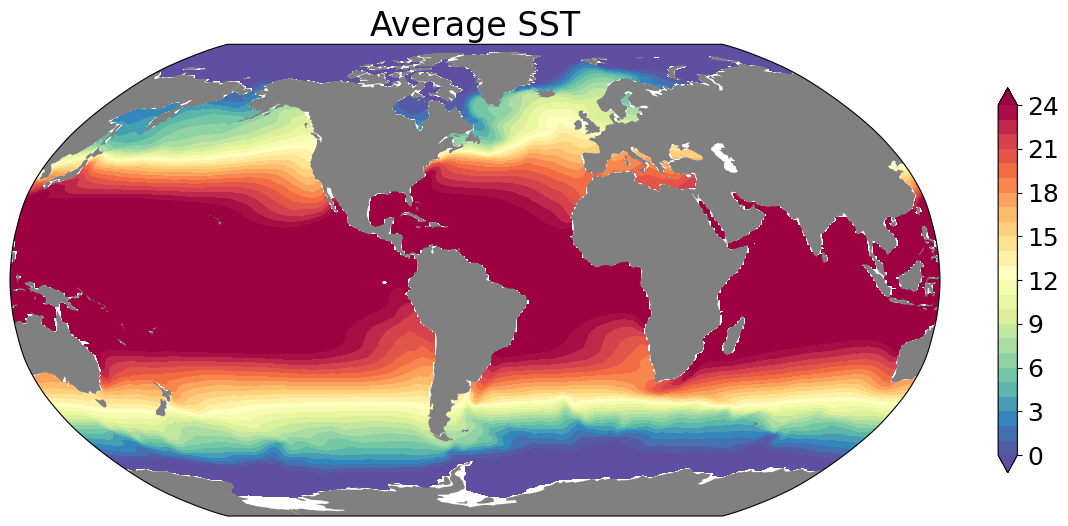

In [10]:
fig = plt.figure(figsize=(15, 10))
lev = np.arange(0, 25,1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=12.5)
x_lon = ds.TLONG
y_lat= ds.TLAT

## SSP5 
# Historical 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
x,y, data = adjust_pop_grid(x_lon, y_lat,np.nanmean(temp[:,:,:],axis=(0)))
cf = ax.contourf(x, y, data, cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
ax.set_global()
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Average SST', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.tick_params(labelsize=18)

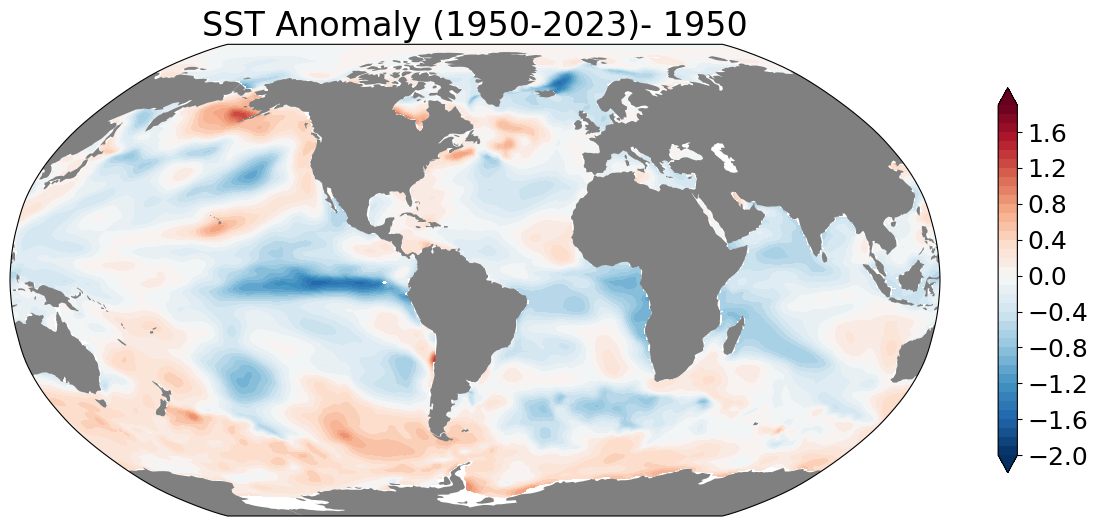

In [11]:
fig = plt.figure(figsize=(15, 10))
lev = np.arange(-2, 2,0.1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0)
x_lon = ds.TLONG
y_lat= ds.TLAT

## SSP5 
# Historical 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
x,y, data = adjust_pop_grid(x_lon, y_lat,np.nanmean(temp[:, :, :],axis=0)-temp[0, :, :])
cf = ax.contourf(x, y, data, cmap='RdBu_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
ax.set_global()
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('SST Anomaly (1950-2023)- 1950', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.tick_params(labelsize=18)

In [106]:
(temp[0, :, :]-temp[0, :, :]).shape

(384, 320)

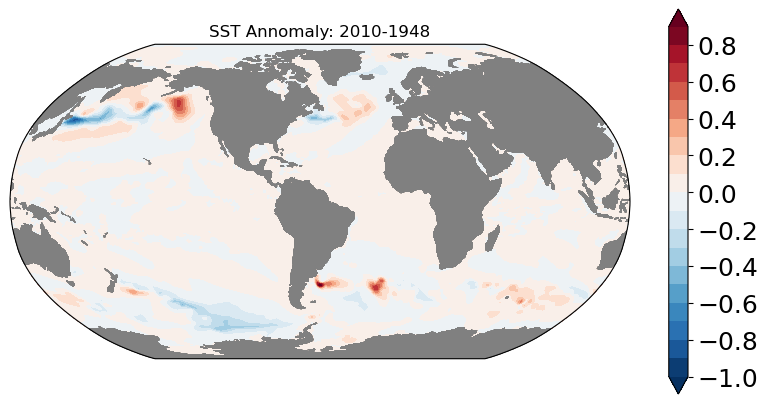

CPU times: user 4min 31s, sys: 6.08 s, total: 4min 37s
Wall time: 5min 1s


In [15]:
%%time
from matplotlib.animation import FuncAnimation
lev = np.arange(-1, 1,0.1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0)
list_of_years = ["1948","1949",
         "1950",'1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))

x_lon = ds.TLONG
y_lat= ds.TLAT

x,y, data = adjust_pop_grid(x_lon, y_lat, temp[0, :, :]-temp[0, :, :])
cf = ax.contourf(x, y, data, cmap='RdBu_r', levels=lev, norm=norm, extend='both', transform=ccrs.PlateCarree())
ax.set_global()
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend='both')
cbar.ax.tick_params(labelsize=18)
title = ax.set_title('Temperature - ' + list_of_years[0])

def update(frame):
    x,y,data = adjust_pop_grid(x_lon, y_lat,temp[frame, :, :]-temp[0, :, :])
    cf = ax.contourf(x, y, data, cmap='RdBu_r', levels=lev, norm=norm, extend='both', transform=ccrs.PlateCarree())
    ax.set_global()
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '110m', facecolor='gray'))
    cf.set_array(data.flatten())
    title.set_text('SST Annomaly: ' + list_of_years[frame]+'-1948')
    return cf, title

ani = FuncAnimation(fig, update, frames=len(list_of_years), interval=200)
ani.save('temperature_animation_annual_annomaly_1950_spectra.mp4', writer='ffmpeg', fps=1)

plt.show()

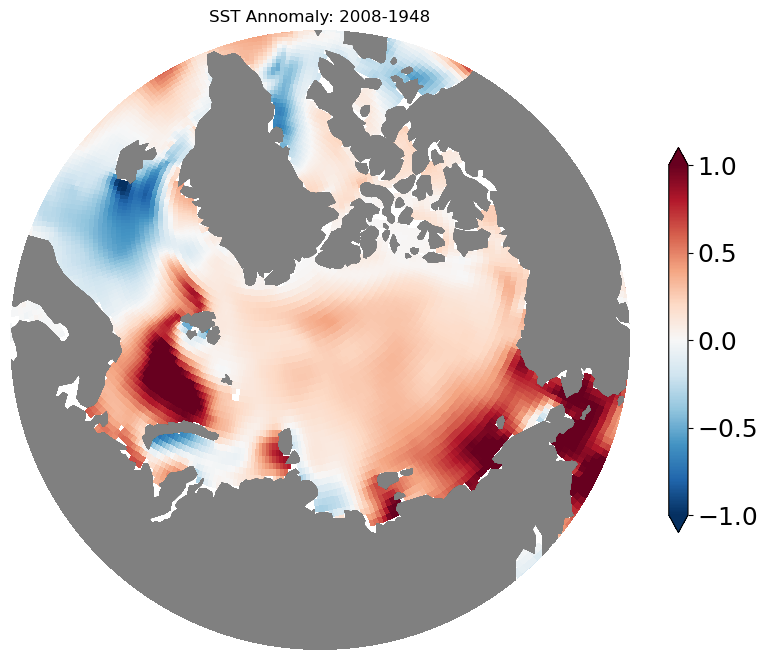

CPU times: user 14min 51s, sys: 10.3 s, total: 15min 1s
Wall time: 17min 57s


In [38]:
%%time
import cartopy.crs as ccrs
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

list_of_years = list(range(1948, 2009, 1))

#-------------------- Cartopy Settings -------------------------------
r_limit = 3214068.5
r_extent = r_limit*1.0001
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=180+(-100+-30)/2, central_latitude=90)
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,circle_path.codes.copy())
vminn=-1
vmaxx=1
temp_62yr = temp[0:61,:,:]
#---------------------------------------------------------------------
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1,projection=my_projn)
#---------------------------------------------------------------------

x,y, data = adjust_pop_grid(x_lon, y_lat, temp_62yr[0, :, :]-temp_62yr[0, :, :])
cf = ax.pcolormesh(x, y, data, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame
cbar = plt.colorbar(cf, shrink=0.5, extend='both')
cbar.ax.tick_params(labelsize=18)
title = ax.set_title('Temperature - ' + str(list_of_years[0]))

def update(frame):
    x,y,data = adjust_pop_grid(x_lon, y_lat,temp_62yr[frame, :, :]-temp_62yr[0, :, :])
    cf = ax.pcolormesh(x, y, data, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj)
    ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
    ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
    ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame
    cf.set_array(data.flatten())
    title.set_text('SST Annomaly: ' + str(list_of_years[frame])+'-1948')
    return cf, title

ani = FuncAnimation(fig, update, frames=len(list_of_years), interval=200)
ani.save('temperature_animation_ao_annual_annomaly_1948_spectra.mp4', writer='ffmpeg', fps=50, dpi=600)

plt.show()

In [44]:
years = np.arange(1948, 2009)
len(years)

61

## Import a mask to look at the Arctic Ocean

In [17]:
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import pop_tools

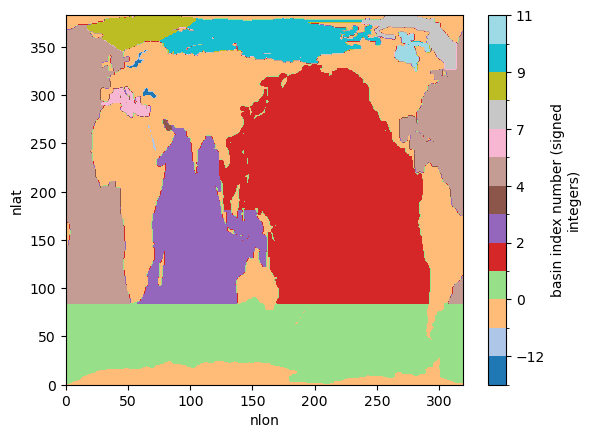

In [18]:
grid_name = 'POP_gx1v7'

dz = pop_tools.get_grid(grid_name)
regions = np.array(np.unique(dz.REGION_MASK))
regions
dz.REGION_MASK.plot.contourf(levels=regions, cmap='tab20');

In [19]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='default')
mask3d.region

<xarray.DataArray 'region' (region: 13)>
array(['Black Sea', 'Baltic Sea', 'Red Sea', 'Southern Ocean', 'Pacific Ocean',
       'Indian Ocean', 'Persian Gulf', 'Atlantic Ocean', 'Mediterranean Sea',
       'Lab. Sea & Baffin Bay', 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'],
      dtype='<U21')
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'

In [20]:
AO   = np.where(mask3d.sel(region='Arctic Ocean').values==1)

In [35]:
arctic_temperatures[0:61].shape

(61,)

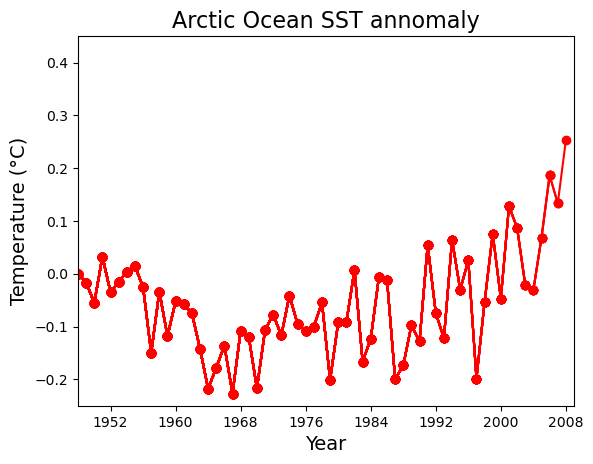

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.ticker import MaxNLocator

# Annual Average Temperature Over Time
years = np.arange(1948, 2009)
arctic_temperatures = np.nanmean(temp[0:61,AO[0],AO[1]],axis=(1))

# Set up the figure
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Year',fontsize=14)
plt.ylabel('Temperature (°C)',fontsize=14)
plt.title('Arctic Ocean SST annomaly',fontsize=16)
plt.xlim(1948,2009)
plt.ylim(-0.25,0.45)

def update(frame):
    cf = ax.plot(years[:frame+1], arctic_temperatures[:frame+1]-arctic_temperatures[0], marker='o', color='red')
    plt.xlim(1948,2009)
    plt.ylim(-0.25,0.45)
    return cf

ani = FuncAnimation(fig, update, frames=len(years), interval=200)
ani.save('temperature_timeseries_ao_spectra.mp4', writer='ffmpeg', fps=10, dpi=600)

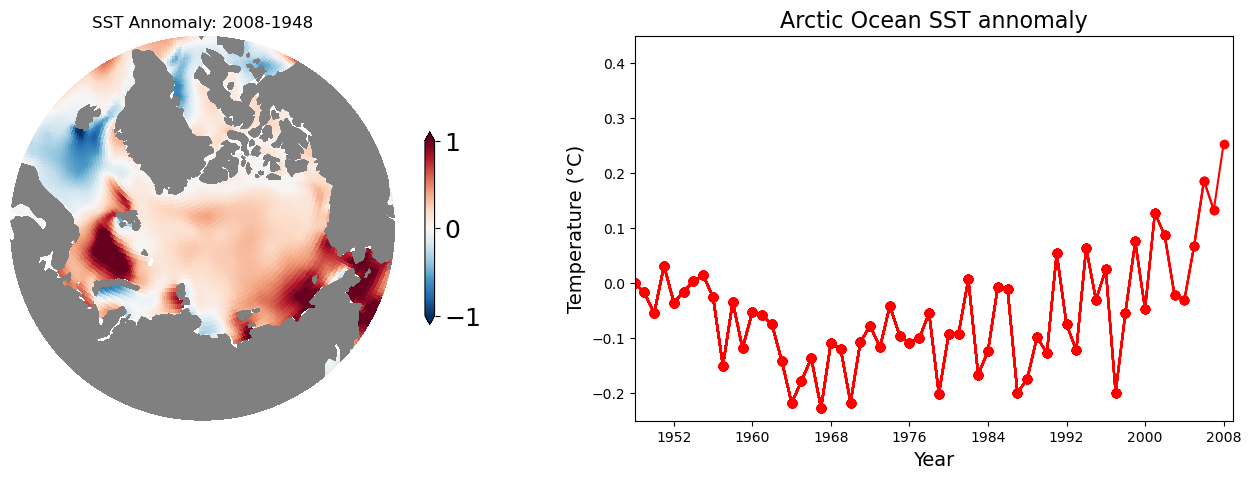

CPU times: user 9min 43s, sys: 8.63 s, total: 9min 52s
Wall time: 11min 44s


In [40]:
%%time
import cartopy.crs as ccrs
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])



#-------------------- Cartopy Settings -------------------------------
r_limit = 3214068.5
r_extent = r_limit*1.0001
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=180+(-100+-30)/2, central_latitude=90)
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,circle_path.codes.copy())
vminn=-1
vmaxx=1

#---------------------------------------------------------------------
fig = plt.figure(figsize=(17, 5))
ax = fig.add_subplot(1, 2, 1,projection=my_projn)
#---------------------------------------------------------------------

x,y, data = adjust_pop_grid(x_lon, y_lat, temp_62yr[0, :, :]-temp_62yr[0, :, :])
cf = ax.pcolormesh(x, y, data, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame
cbar = plt.colorbar(cf, shrink=0.5, extend='both')
cbar.ax.tick_params(labelsize=18)
title = ax.set_title('Temperature - ' + str(list_of_years[0]))

# Annual Average Temperature Over Time
years = np.arange(1948, 2009)
arctic_temperatures = np.nanmean(temp[0:61,AO[0],AO[1]],axis=(1))

# Set up the figure
ax1 = fig.add_subplot(1, 2, 2)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Year',fontsize=14)
plt.ylabel('Temperature (°C)',fontsize=14)
plt.title('Arctic Ocean SST annomaly',fontsize=16)
plt.xlim(1948,2009)
plt.ylim(-0.25,0.45)

def update(frame):
    x,y,data = adjust_pop_grid(x_lon, y_lat,temp_62yr[frame, :, :]-temp_62yr[0, :, :])
    cf = ax.pcolormesh(x, y, data, cmap='RdBu_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj)
    ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
    ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
    ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame
    cf.set_array(data.flatten())
    title.set_text('SST Annomaly: ' + str(list_of_years[frame])+'-1948')
    ca = ax1.plot(years[:frame+1], arctic_temperatures[:frame+1]-arctic_temperatures[0], marker='o', color='red')
    plt.xlim(1948,2009)
    plt.ylim(-0.25,0.45)
    return cf, ca, title

ani = FuncAnimation(fig, update, frames=len(list_of_years), interval=200)
ani.save('temperature_animation_ao_annual_annomaly_1950_timeseries_spectra.mp4', writer='ffmpeg', fps=10, dpi=600)

plt.show()

## Find the coordiantes to separate the Arctic Ocean, the way that we did for the 1v1 grid in SPECTRA

| Initials  | Name                       | Latitude          | Longitude             |
|-----------|----------------------------|-------------------|-----------------------|
| `ao`      | Central Arctic             | $90^oN$ to $80^oN$ |  All                 |
| `cs`      | Chukchi Sea                | $80^oN$ to $60^oN$ |$-180^o$ to $-155^oW$ |
| `bs`      | Beaufort Sea               | $80^oN$ to $60^oN$ |$-155^oW$ to $-125^oW$|
| `ca`      | Canadian Archipelago       | $80^oN$ to $60^oN$ |$-125^oW$ to $-70^oW$ |
| `bb`      | Baffin Sea                 | $80^oN$ to $60^oN$ |$-70^oW$ to $-45^oW$  |                      
| `ess`     | Eastern Siberian Sea       | $80^oN$ to $60^oN$ |$145^oE$ to $180^o$   |                       
| `ls`      | Laptev Sea                 | $80^oN$ to $60^oN$ |$90^oE$ to $145^oE$   |                      
| `ks`      | Kara Sea                   | $80^oN$ to $60^oN$ |$53^oE$ to $90^oE$    |                      
| `bts`     | Barents Sea                | $80^oN$ to $60^oN$ |$20^oE$ to $53^oE$    |                      
| `ns`      | Nordic Sea                 | $80^oN$ to $60^oN$ |$-45^oW$ to $20^oE$   | 

### Check if a point corresponds to the lat and lons that we expect

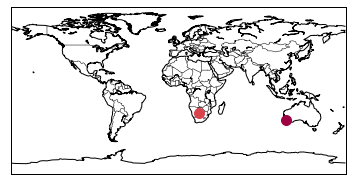

In [57]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
 
map = Basemap()
cmap=matplotlib.cm.get_cmap('Spectral', 10)
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'white')
map.drawmapboundary()
lon = sst_obs.lon[58]
lat = sst_obs.lat[60]
x,y = map(lon, lat)
map.plot(x, y, 'o', markersize=10,color=cmap(0))
lon1 = sst_obs.lon[11]
lat1 = sst_obs.lat[56]
x1,y1 = map(lon1, lat1)
map.plot(x1, y1, 'o', markersize=10,color=cmap(1))
#map.plot(pp_ds.ppChl[0,0,100, 300], 'bo', markersize=24) 
plt.show()

### These are defintiely not where the points should be, they should be in the BATS and HOT Station, so I need to figure out how this works

In [8]:
#labels = (['Central Arctic', 'Chukchi Sea', 'Beaufort Sea','Canadian Archipelago',
#                     'Baffin Sea','Nordic Sea','Barents Sea','Kara Sea','Laptev Sea',
#                     'East Siberian Sea'])

arctic = np.zeros((12,89,180))
# Central Arctic 
for j in range(0,4):
    arctic[:,j,:] = 0 

# Chukchi Sea
for i in range(90,103): # I am trying to maybe go backwayrs, and half 180-(25/2) = 12
    for j in range(4,12):
        arctic[:,j,i] = 1 # 

# Beaufort Sea        
for i in range(103,118): # 55-25 = 30/2 = 15 
    for j in range(4,12):
        arctic[:,j,i] = 2

# Canadian Archipelago        
for i in range(118,145): # 110- 55/2 = 27
    for j in range(4,12):
        arctic[:,j,i] = 3
        
# Baffin Sea        
for i in range(145,158): # 135- 110/2 = 12
    for j in range(4,12):
        arctic[:,j,i] = 4

# Nordic Sea        
for i in range(72,90): # (360-325)/2 =  17
    for j in range(4,12):
        arctic[:,j,i] = 9

# Barents Sea        
for i in range(44,72): # (325-270)/2 = 27
    for j in range(4,12):
        arctic[:,j,i] = 8

# Kara Sea        
for i in range(26,44): # (270-233)/2 = 18
    for j in range(4,12):
        arctic[:,j,i] = 7

# Laptev Sea        
for i in range(10,26): # (233-200)/2 = 16
    for j in range(4,12):
        arctic[:,j,i] = 6

# East Siberian Sea        
for i in range(158,180): # (200-135)/2 = 32
    for j in range(4,12):
        arctic[:,j,i] = 5

# East Siberian Sea         
for i in range(0,10): # (200-135)/2 = 32
    for j in range(4,12):
        arctic[:,j,i] = 5

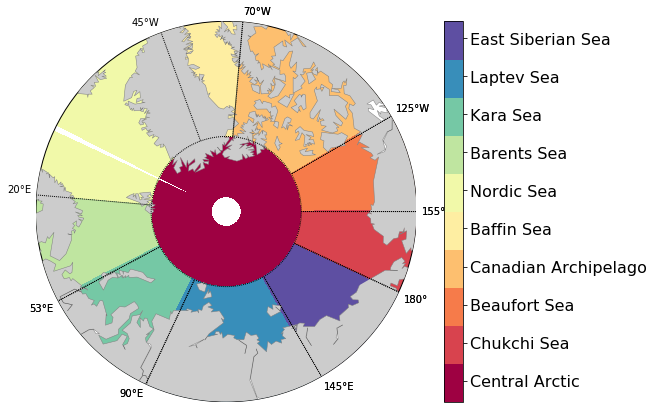

In [9]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
m = Basemap(projection='npstere',round=True,
            boundinglat=65,
            lon_0=180+(-100+-30)/2.,resolution='c')

x, y = m(*np.meshgrid(sst_obs.lon,sst_obs.lat))

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

m.pcolormesh(x,y,arctic[0,:,:],shading='flat',cmap=plt.cm.get_cmap('Spectral', 10))
cbar=plt.colorbar() 
cbar.set_ticks([0.5,1.4,2.3,3.2,4.1,5.0,5.9,6.8,7.7,8.6])
cbar.set_ticklabels(['Central Arctic', 'Chukchi Sea', 'Beaufort Sea','Canadian Archipelago',
                     'Baffin Sea','Nordic Sea','Barents Sea','Kara Sea','Laptev Sea',
                     'East Siberian Sea'])
cbar.ax.tick_params(labelsize=16)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)
m.plot
plt.show()

## Seasonality and interannual variability throughout the Arcitc Ocean

In [10]:
obs_ao = np.nanmean(temp[95:156,:,0:4,:], axis=(2,3))
obs_cs = np.nanmean(temp[95:156,:,4:12,90:103], axis=(2,3))
obs_bs = np.nanmean(temp[95:156,:,4:12,103:118], axis=(2,3))
obs_ca = np.nanmean(temp[95:156,:,4:12,118:145], axis=(2,3))
obs_bb = np.nanmean(temp[95:156,:,4:12,145:158], axis=(2,3))
obs_ns = np.nanmean(temp[95:156,:,4:12,72:90], axis=(2,3))
obs_bts =np.nanmean(temp[95:156,:,4:12,44:72], axis=(2,3))
obs_ks = np.nanmean(temp[95:156,:,4:12,26:44], axis=(2,3))
obs_ls = np.nanmean(temp[95:156,:,4:12,10:26], axis=(2,3))
obs_ess = np.nanmean(temp[95:156,:,4:12,0:10], axis=(2,3))
obs_ess1 = np.nanmean(temp[95:156,:,4:12,158:180], axis=(2,3))

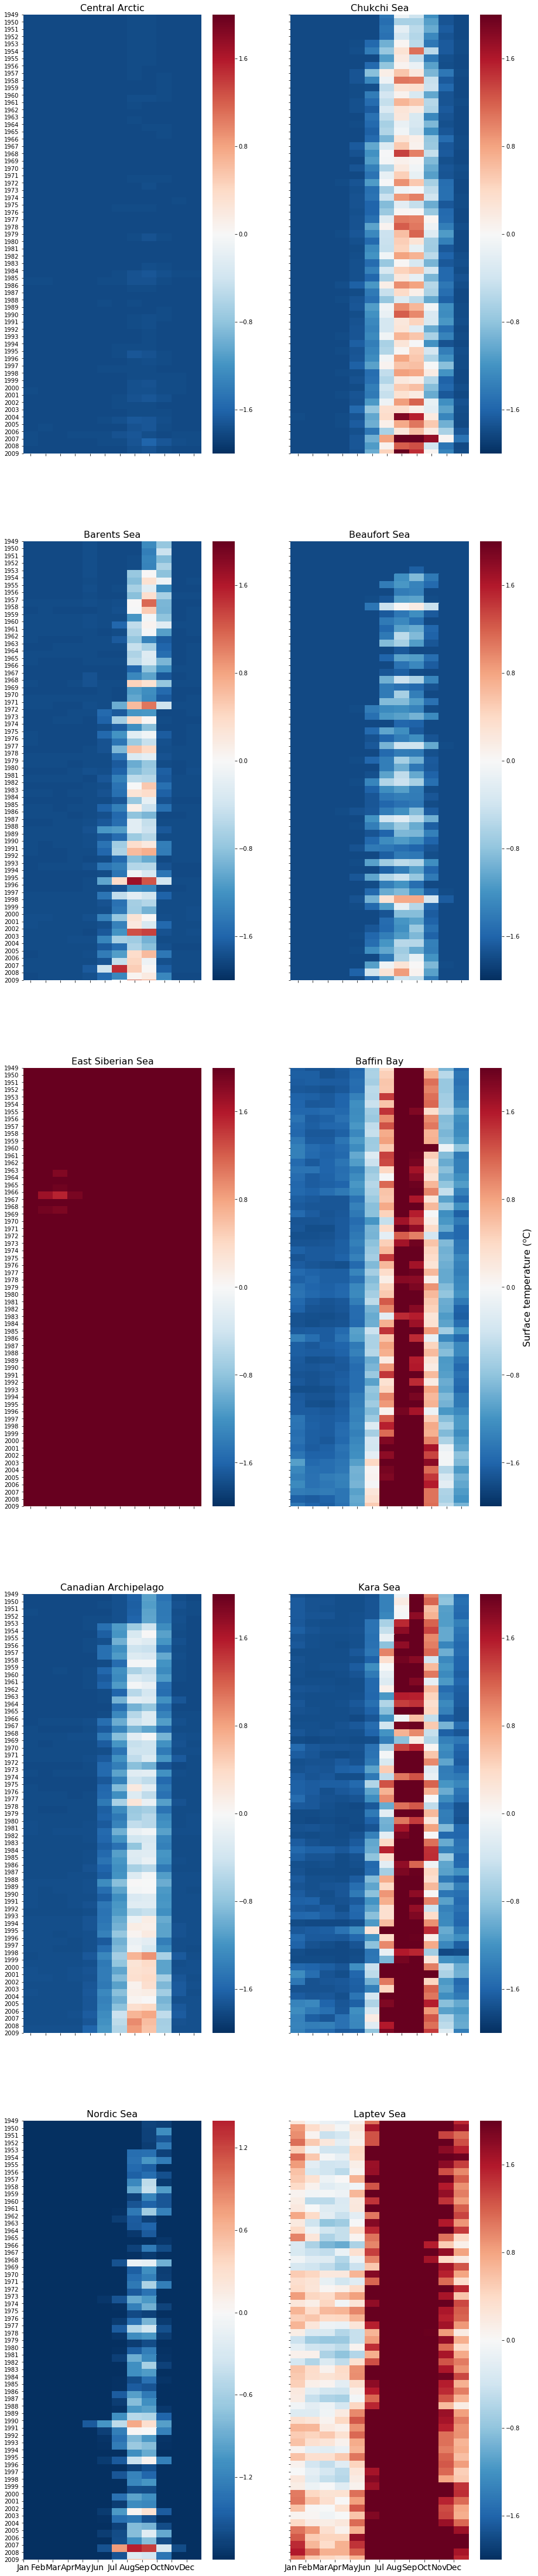

In [11]:
from matplotlib.gridspec import GridSpec
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = ['1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
fig = plt.figure(figsize=(15, 80))
gs = GridSpec(nrows=5, ncols=2)


#subplot 1
ax0 = fig.add_subplot(gs[0, 0])
ax= sns.heatmap(obs_ao,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Central Arctic', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[0, 1])
ax= sns.heatmap(obs_cs,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Chukchi Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[1, 1])
axx2= sns.heatmap(obs_bs,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
axx2.set_yticklabels(''); axx2.set_xticklabels('')
axx2.set_title('Beaufort Sea', fontsize=16)
plt.setp(axx2.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = axx2.collections[0].colorbar

ax0 = fig.add_subplot(gs[1, 0])
ax= sns.heatmap(obs_bts,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Barents Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[2, 0])
ax= sns.heatmap(obs_ess,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('East Siberian Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[3, 0])
ax= sns.heatmap(obs_ca,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Canadian Archipelago', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[4, 0])
ax= sns.heatmap(obs_ns,center=0,cmap="RdBu_r")
ax.set_yticks(np.arange(len(years))); ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Nordic Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[3, 1])
ax= sns.heatmap(obs_ks,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Kara Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[4, 1])
ax= sns.heatmap(obs_ls,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(''); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Laptev Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[2, 1])
ax= sns.heatmap(obs_bb,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Baffin Bay', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar
cbar.set_label('Surface temperature ($^o$C) ', fontsize =16)

## Create a plot with seasonality in temperature, and interannual variation. 

In [12]:
# This is the error on the observations
err_ao = np.nanstd(obs_ao,axis=0)
err_cs = np.nanstd(obs_cs,axis=0)
err_bs = np.nanstd(obs_bs,axis=0)
err_ca = np.nanstd(obs_ca,axis=0)
err_bb = np.nanstd(obs_bb,axis=0)
err_ess = np.nanstd(obs_ess,axis=0)
err_ls = np.nanstd(obs_ls,axis=0)
err_ns = np.nanstd(obs_ns,axis=0)
err_bts = np.nanstd(obs_bts,axis=0)
err_ks = np.nanstd(obs_ks,axis=0)

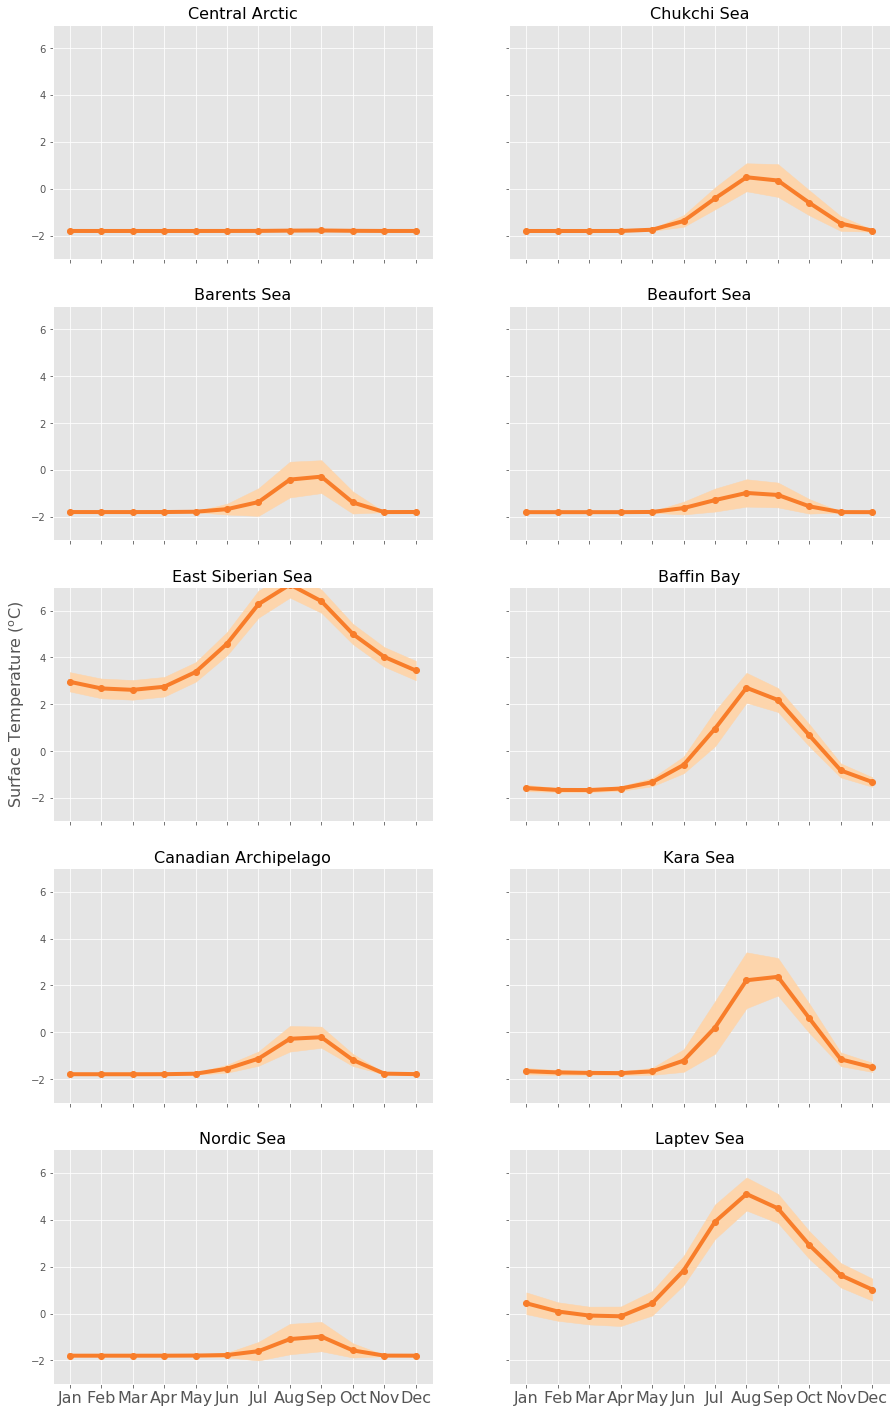

In [13]:
plt.style.use('ggplot')

from matplotlib.gridspec import GridSpec
import matplotlib
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(months,np.nanmean(obs_ao,axis=0), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(months, np.nanmean(obs_ao,axis=0)-err_ao,np.nanmean(obs_ao,axis=0)+err_ao, color=cmap(2))
ax1.set_title('Central Arctic', fontsize=16); #ax1.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax1.set_ylim(-3,7);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(months,np.nanmean(obs_bts,axis=0), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(months, np.nanmean(obs_bts,axis=0)-err_bts,np.nanmean(obs_bts,axis=0)+err_bts, color=cmap(2))
ax2.set_title('Barents Sea', fontsize=16); #ax2.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax2.set_ylim(-3,7);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(months,np.nanmean(obs_cs,axis=0), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(months, np.nanmean(obs_cs,axis=0)-err_cs,np.nanmean(obs_cs,axis=0)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(-3,7);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(months,np.nanmean(obs_ess,axis=0), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(months, np.nanmean(obs_ess,axis=0)-err_ess,np.nanmean(obs_ess,axis=0)+err_ess, color=cmap(2))
ax4.set_ylabel('Surface Temperature ($^o$C)', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); #ax4.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax4.set_ylim(-3,7);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(months,np.nanmean(obs_ca,axis=0), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(months, np.nanmean(obs_ca,axis=0)-err_ca,np.nanmean(obs_ca,axis=0)+err_ca, color=cmap(2))
ax5.set_title('Canadian Archipelago', fontsize=16); #ax5.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax5.set_ylim(-3,7);
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(months,np.nanmean(obs_ns,axis=0), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(months, np.nanmean(obs_ns,axis=0)-err_ns,np.nanmean(obs_ns,axis=0)+err_ns, color=cmap(2))
ax6.set_title('Nordic Sea', fontsize=16); #ax6.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax6.set_ylim(-3,7);
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(months,np.nanmean(obs_bs,axis=0), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(months, np.nanmean(obs_bs,axis=0)-err_bs,np.nanmean(obs_bs,axis=0)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(-3,7);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(months,np.nanmean(obs_bb,axis=0), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(months, np.nanmean(obs_bb,axis=0)-err_bb,np.nanmean(obs_bb,axis=0)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(-3,7);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(months,np.nanmean(obs_ks,axis=0), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(months, np.nanmean(obs_ks,axis=0)-err_ks,np.nanmean(obs_ks,axis=0)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(-3,7);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(months,np.nanmean(obs_ls,axis=0), '-o', color=cmap(5),linewidth=4)
ax.fill_between(months, np.nanmean(obs_ls,axis=0)-err_ls,np.nanmean(obs_ls,axis=0)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)
ax.set_ylim(-3,7);  ax.set_yticklabels(''); 
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/SST_observations_interannual_climatology',dpi=600, bbox_inches='tight')

plt.show()

## Create one plot in every region, with annual temperature at every year, and monthly variability in the error bars?. 

In [14]:
# This is the error on the observations
err_ao = np.nanstd(obs_ao,axis=1)
err_cs = np.nanstd(obs_cs,axis=1)
err_bs = np.nanstd(obs_bs,axis=1)
err_ca = np.nanstd(obs_ca,axis=1)
err_bb = np.nanstd(obs_bb,axis=1)
err_ess = np.nanstd(obs_ess,axis=1)
err_ls = np.nanstd(obs_ls,axis=1)
err_ns = np.nanstd(obs_ns,axis=1)
err_bts = np.nanstd(obs_bts,axis=1)
err_ks = np.nanstd(obs_ks,axis=1)

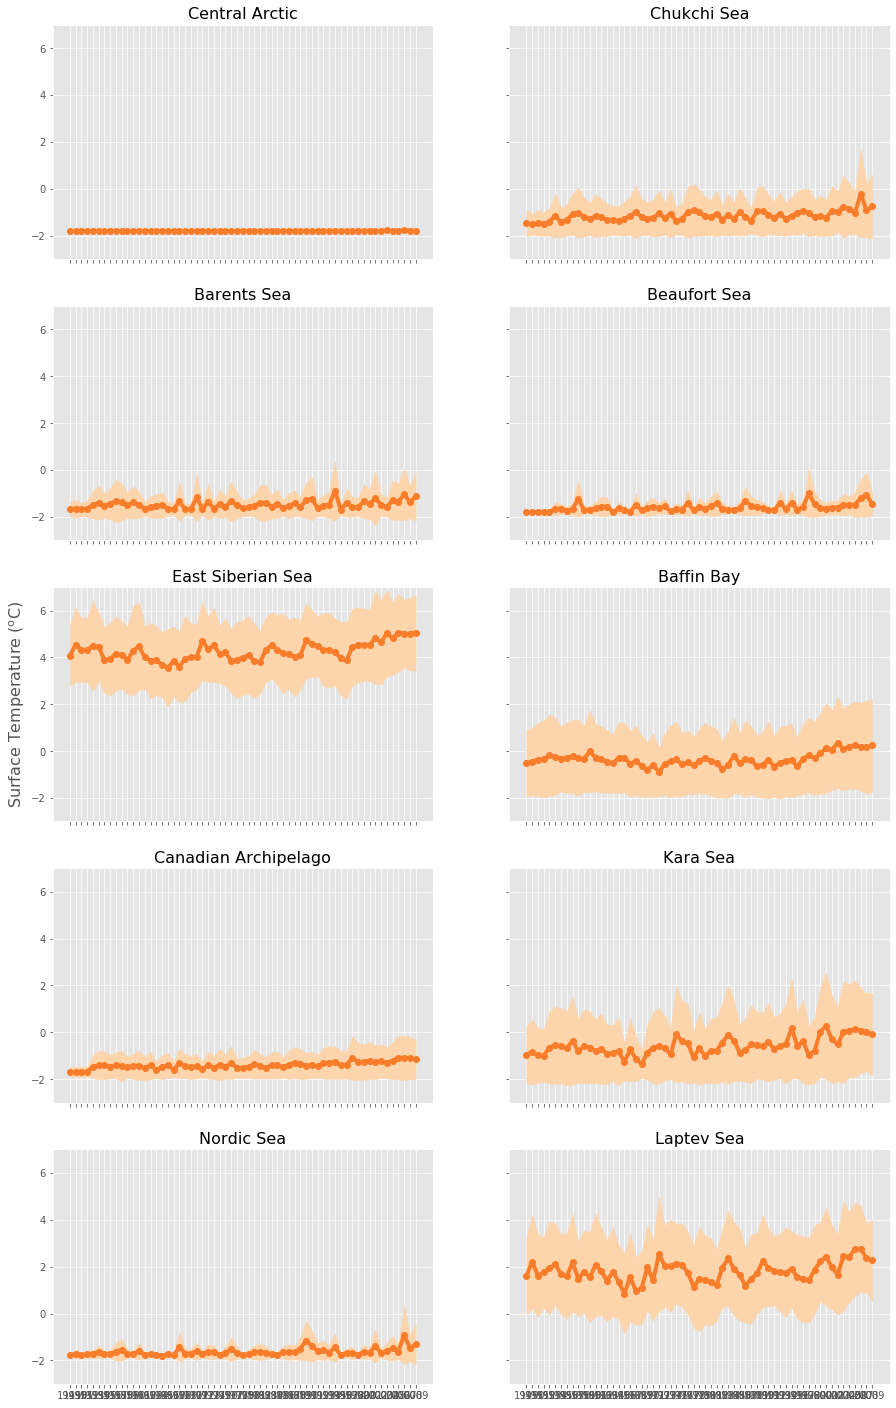

In [15]:
plt.style.use('ggplot')

from matplotlib.gridspec import GridSpec
import matplotlib
years = ['1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(years,np.nanmean(obs_ao,axis=1), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(years, np.nanmean(obs_ao,axis=1)-err_ao,np.nanmean(obs_ao,axis=1)+err_ao, color=cmap(2))
ax1.set_title('Central Arctic', fontsize=16); #ax1.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax1.set_ylim(-3,7);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(years,np.nanmean(obs_bts,axis=1), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(years, np.nanmean(obs_bts,axis=1)-err_bts,np.nanmean(obs_bts,axis=1)+err_bts, color=cmap(2))
ax2.set_title('Barents Sea', fontsize=16); #ax2.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax2.set_ylim(-3,7);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(years,np.nanmean(obs_cs,axis=1), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(years, np.nanmean(obs_cs,axis=1)-err_cs,np.nanmean(obs_cs,axis=1)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(-3,7);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(years,np.nanmean(obs_ess,axis=1), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(years, np.nanmean(obs_ess,axis=1)-err_ess,np.nanmean(obs_ess,axis=1)+err_ess, color=cmap(2))
ax4.set_ylabel('Surface Temperature ($^o$C)', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); #ax4.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax4.set_ylim(-3,7);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(years,np.nanmean(obs_ca,axis=1), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(years, np.nanmean(obs_ca,axis=1)-err_ca,np.nanmean(obs_ca,axis=1)+err_ca, color=cmap(2))
ax5.set_title('Canadian Archipelago', fontsize=16); #ax5.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax5.set_ylim(-3,7); 
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(years,np.nanmean(obs_ns,axis=1), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(years, np.nanmean(obs_ns,axis=1)-err_ns,np.nanmean(obs_ns,axis=1)+err_ns, color=cmap(2))
ax6.set_title('Nordic Sea', fontsize=16); #ax6.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax6.set_ylim(-3,7);
ax6.set_xticklabels(['1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(years,np.nanmean(obs_bs,axis=1), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(years, np.nanmean(obs_bs,axis=1)-err_bs,np.nanmean(obs_bs,axis=1)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(-3,7);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(years,np.nanmean(obs_bb,axis=1), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(years, np.nanmean(obs_bb,axis=1)-err_bb,np.nanmean(obs_bb,axis=1)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(-3,7);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(years,np.nanmean(obs_ks,axis=1), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(years, np.nanmean(obs_ks,axis=1)-err_ks,np.nanmean(obs_ks,axis=1)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(-3,7);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(years,np.nanmean(obs_ls,axis=1), '-o', color=cmap(5),linewidth=4)
ax.fill_between(years, np.nanmean(obs_ls,axis=1)-err_ls,np.nanmean(obs_ls,axis=1)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
ax.set_ylim(-3,7);  ax.set_yticklabels(''); 
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/SST_observations_annual_climatology',dpi=600, bbox_inches='tight')

plt.show()

## Now let's try to make an anomaly plot

In [18]:
temp_ao = np.nanmean(temp[94:156,:,0:4,:], axis=(2,3))
temp_cs = np.nanmean(temp[94:156,:,4:12,90:103], axis=(2,3))
temp_bs = np.nanmean(temp[94:156,:,4:12,103:118], axis=(2,3))
temp_ca = np.nanmean(temp[94:156,:,4:12,118:145], axis=(2,3))
temp_bb = np.nanmean(temp[94:156,:,4:12,145:158], axis=(2,3))
temp_ns = np.nanmean(temp[94:156,:,4:12,72:90], axis=(2,3))
temp_bts =np.nanmean(temp[94:156,:,4:12,44:72], axis=(2,3))
temp_ks = np.nanmean(temp[94:156,:,4:12,26:44], axis=(2,3))
temp_ls = np.nanmean(temp[94:156,:,4:12,10:26], axis=(2,3))
temp_ess = np.nanmean(temp[94:156,:,4:12,0:10], axis=(2,3))
temp_ess1 = np.nanmean(temp[94:156,:,4:12,158:180], axis=(2,3))

In [19]:
temp_ao.shape

(62, 12)

In [20]:
temp_ao_anom = temp_ao-np.nanmean(temp_ao,axis=0)
temp_cs_anom = temp_cs-np.nanmean(temp_cs,axis=0)
temp_bs_anom = temp_bs-np.nanmean(temp_bs,axis=0)
temp_ca_anom = temp_ca-np.nanmean(temp_ca,axis=0)
temp_bb_anom = temp_bb-np.nanmean(temp_bb,axis=0)
temp_ess_anom = temp_ess-np.nanmean(temp_ess,axis=0)
temp_ls_anom = temp_ls-np.nanmean(temp_ls,axis=0)
temp_ns_anom = temp_ns-np.nanmean(temp_ns,axis=0)
temp_bts_anom =temp_bts-np.nanmean(temp_bts,axis=0)
temp_ks_anom = temp_ks-np.nanmean(temp_ks,axis=0)

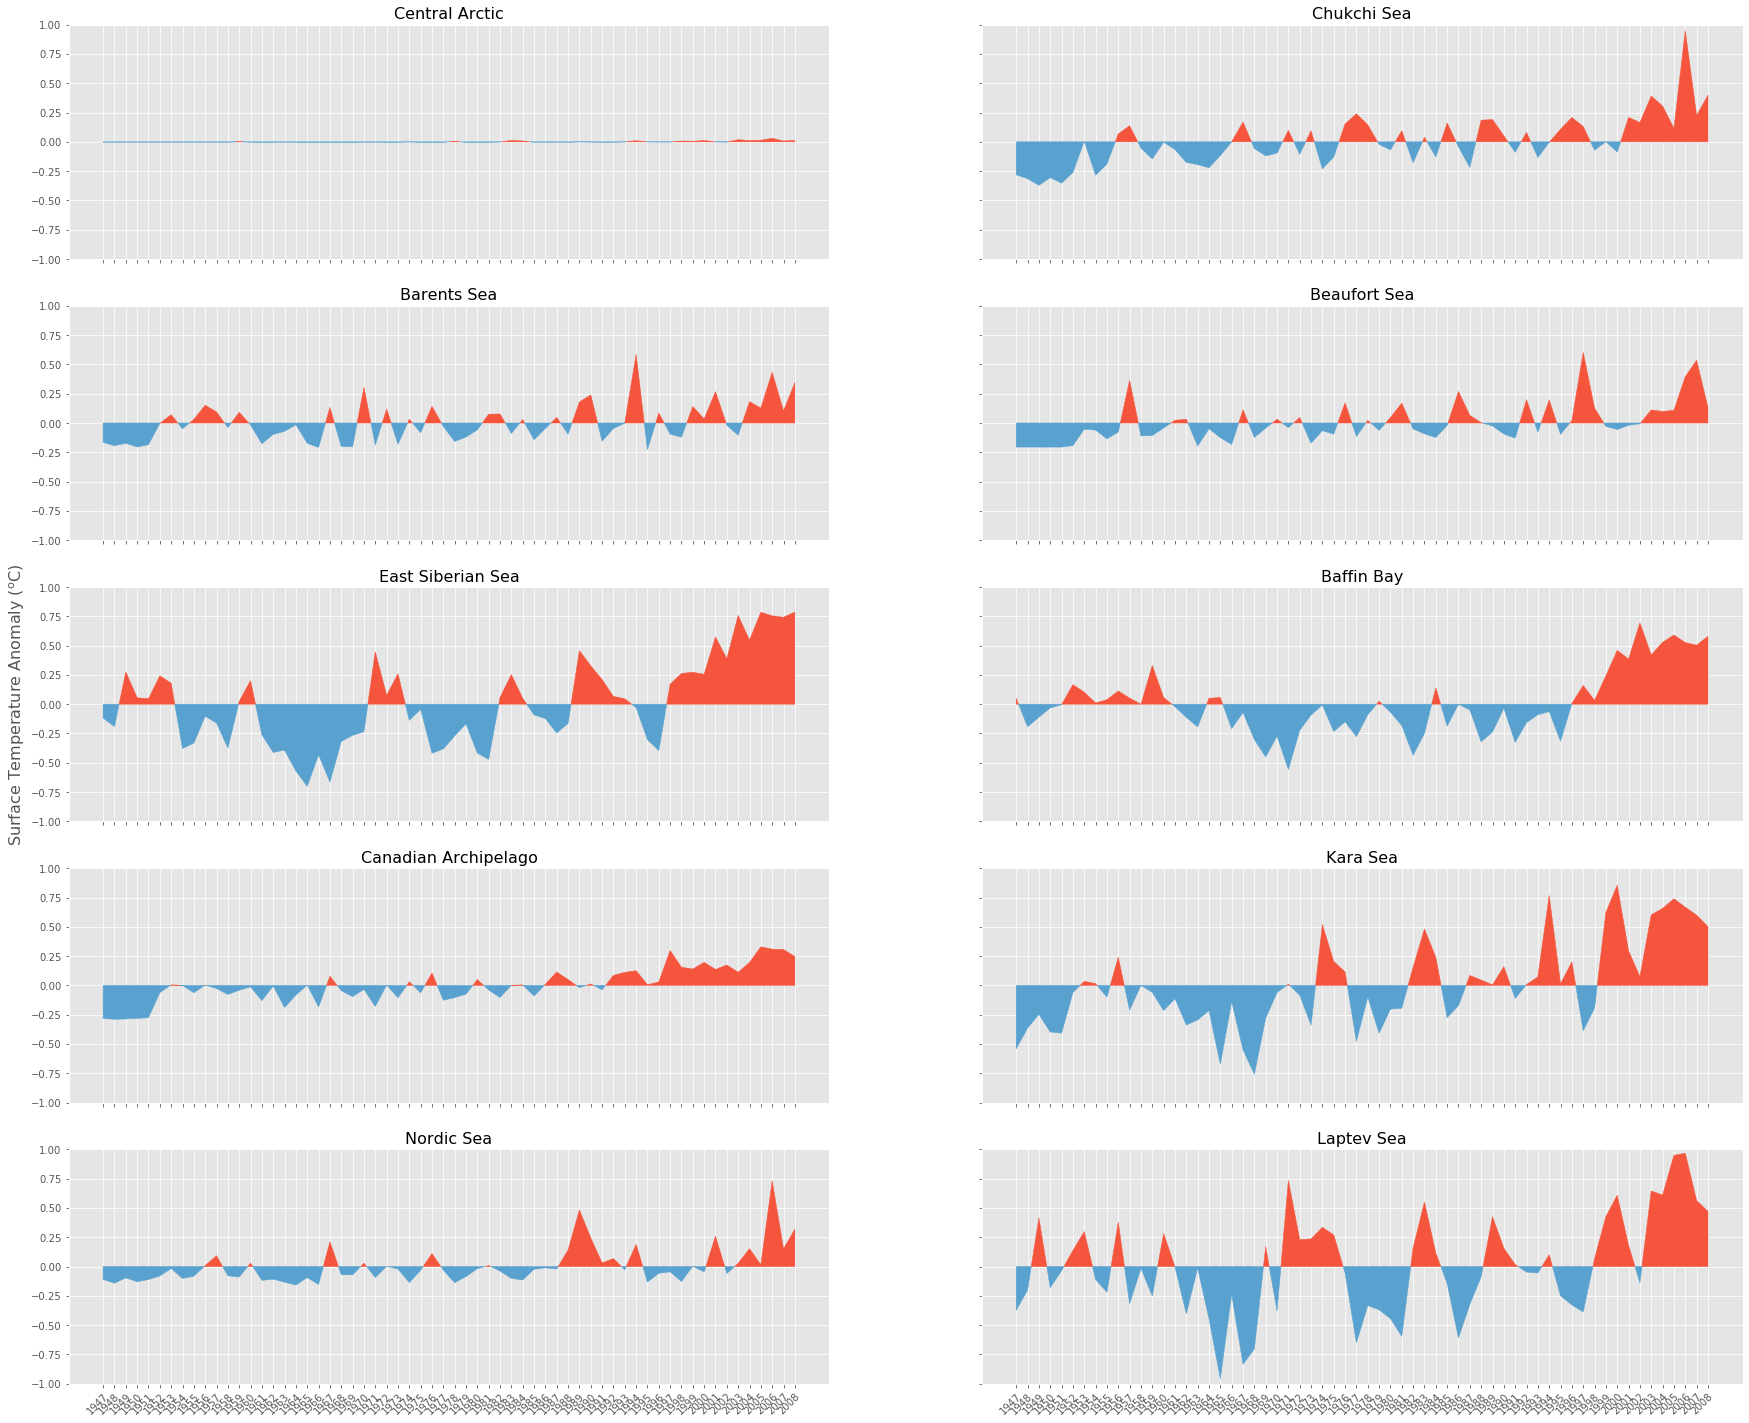

In [22]:
plt.style.use('ggplot')

years = [ '1948', '1949',
         '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959',
         "1960",  '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
         "1970", '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
         "1980", '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
         "1990", '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
         '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(30, 25))
gs = GridSpec(nrows=5, ncols=2)

ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(temp_ao_anom,axis=1), where=np.nanmean(temp_ao_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax1.fill_between(years, np.nanmean(temp_ao_anom,axis=1), where=np.nanmean(temp_ao_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax1.set_title('Central Arctic', fontsize=16); 
ax1.set_ylim(-1,1);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
ax2.fill_between(years, np.nanmean(temp_bts_anom,axis=1), where=np.nanmean(temp_bts_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax2.fill_between(years, np.nanmean(temp_bts_anom,axis=1), where=np.nanmean(temp_bts_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax2.set_title('Barents Sea', fontsize=16); 
ax2.set_ylim(-1,1);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
ax3.fill_between(years, np.nanmean(temp_cs_anom,axis=1), where=np.nanmean(temp_cs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax3.fill_between(years, np.nanmean(temp_cs_anom,axis=1), where=np.nanmean(temp_cs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(-1,1);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
ax4.fill_between(years, np.nanmean(temp_ess_anom,axis=1), where=np.nanmean(temp_ess_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax4.fill_between(years, np.nanmean(temp_ess_anom,axis=1), where=np.nanmean(temp_ess_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax4.set_ylabel('Surface Temperature Anomaly ($^o$C)', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); 
ax4.set_ylim(-1,1);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
ax5.fill_between(years, np.nanmean(temp_ca_anom,axis=1), where=np.nanmean(temp_ca_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax5.fill_between(years, np.nanmean(temp_ca_anom,axis=1), where=np.nanmean(temp_ca_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax5.set_title('Canadian Archipelago', fontsize=16); 
ax5.set_ylim(-1,1);
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
ax6.fill_between(years, np.nanmean(temp_ns_anom,axis=1), where=np.nanmean(temp_ns_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax6.fill_between(years, np.nanmean(temp_ns_anom,axis=1), where=np.nanmean(temp_ns_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax6.set_title('Nordic Sea', fontsize=16); 
ax6.set_ylim(-1,1);
ax6.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax6.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax7 = fig.add_subplot(gs[1, 1]);
ax7.fill_between(years, np.nanmean(temp_bs_anom,axis=1), where=np.nanmean(temp_bs_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax7.fill_between(years, np.nanmean(temp_bs_anom,axis=1), where=np.nanmean(temp_bs_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(-1,1);

ax8 = fig.add_subplot(gs[2, 1]);
ax8.fill_between(years, np.nanmean(temp_bb_anom,axis=1), where=np.nanmean(temp_bb_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax8.fill_between(years, np.nanmean(temp_bb_anom,axis=1), where=np.nanmean(temp_bb_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(-1,1);

ax9 = fig.add_subplot(gs[3, 1]);
ax9.fill_between(years, np.nanmean(temp_ks_anom,axis=1), where=np.nanmean(temp_ks_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax9.fill_between(years, np.nanmean(temp_ks_anom,axis=1), where=np.nanmean(temp_ks_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(-1,1);

ax = fig.add_subplot(gs[4,1]);
ax.fill_between(years, np.nanmean(temp_ls_anom,axis=1), where=np.nanmean(temp_ls_anom,axis=1)>=0, interpolate=True, color=cmap(5))
ax.fill_between(years, np.nanmean(temp_ls_anom,axis=1), where=np.nanmean(temp_ls_anom,axis=1)<=0, interpolate=True, color=cmap1(5))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['1947','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
                    "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
                    "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
                    "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
                    "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
                    '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.set_ylim(-1,1);  ax.set_yticklabels(''); 
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/TEMP_anomaly_Observations',dpi=600, bbox_inches='tight')

plt.show()